Бриф
От клиента поступил заказ на исследование восприятия бренда. Универсальные решения плохо учитывают специфику продукции, поэтому бренд хочет провести свое собственное исследование.

С помощью крауд сорсинга мы разметили датасет из нескольких тысяч отзывов. На этих размеченых отзывах необходимо обучить классификатор тональности (отзыв => позитивный/негативный) и оценить его точность.

Этот классификатор затем будет применен к базе исторических данных, а также поставлен на регулярный обсчет новых данных. С его помощью клиент планирует отслеживать динамику позиций бренда и реакцию на маркетинговые активности.

Данные
Можно использовать любой датасет из репозитория Kaggle категории NLP с ключевым словом "sentiment" (там их 255 штук).

https://www.kaggle.com/datasets?search=sentiment&tags=13204-NLP

Единственное требование - в нем должно быть два поля: "текст отзыва" и "размеченый класс". Класс может быть определен:

меткой (positive/negative или postitive/neutral/negative)
рейтингом (1,2,3,4,5) - в этом случае можно замапить на метку таким образом 1,2,3 = negative, 4,5 = positive
Требования
Результат должен быть предоставлен в виде ноутбука с python кодом
В ноутбуке выведен показатель качества модели:
для мультиклассификация это показатель Accuracy
для бинарной классификации это ROC AUC
В ноутбуке должен быть реализован перебор нескольких моделей, чтобы было видно, что это действительно лучший классификатор
Качество классификатора должно быть замерено на тестовой части выборки - если она не предоставляется отдельно, ее можно выделить из датасета самостоятельно (~20-30% выборки)
Оценка
выполнены базовые требования => 7 баллов
доп балл, если используется датасет, который не повторяется у других студентов (здесь скоординируйтесь пожалуйста)
доп балл, если реализован перебор параметров с помощью Grid Search
доп балл, если все чисто и красиво оформлено с комментариями

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [2]:
#Загружаем данные
data=pd.read_csv('/Users/denis/Downloads/amazon_alexa.tsv', sep='\t')
data.shape

(3150, 5)

In [3]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [5]:
#описание данных статистическими показателями
data.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [6]:
#Проверка количества нулевых значений
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

# EDA

/Users/denis/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rating', ylabel='count'>

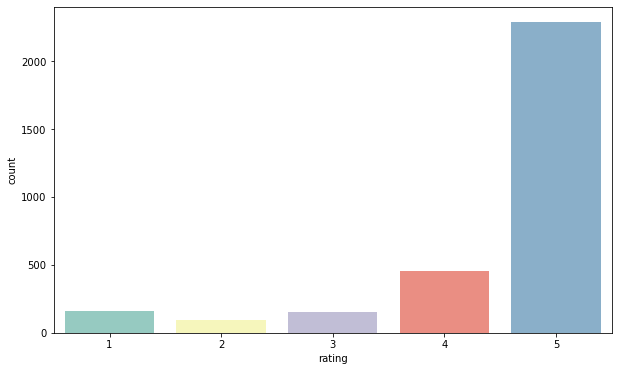

In [7]:
plt.figure(figsize=(10,6))
sns.countplot(data['rating'],palette='Set3')

Пяти бальных отзывов больше 

/Users/denis/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='feedback', ylabel='count'>

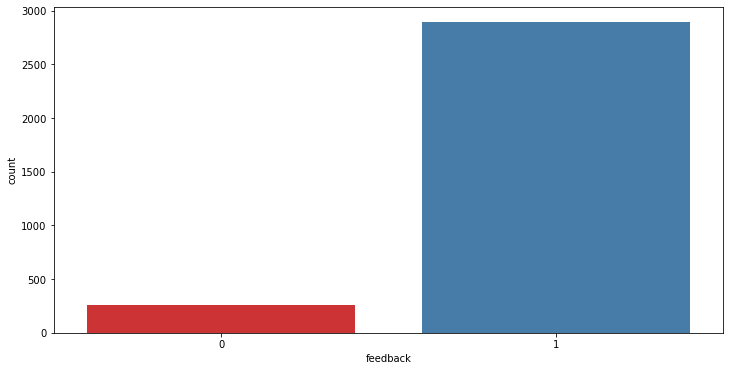

In [8]:
plt.figure(figsize=(12,6))
sns.countplot(data['feedback'], palette='Set1')

/Users/denis/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rating', ylabel='count'>

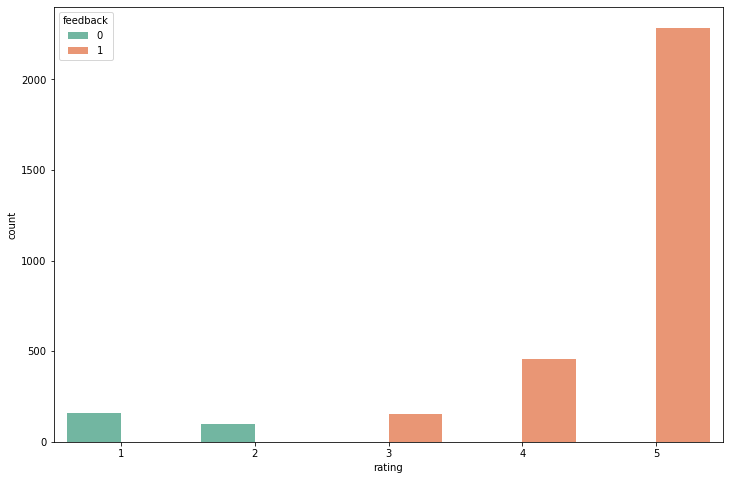

In [9]:
plt.figure(figsize=(12,8))
sns.countplot(data['rating'], hue=data['feedback'], palette='Set2')

Допустим оценки >=4 относятся к положительным отзывам, а оценки 1,2,3 относятся к отрицательным отзывам. 

In [10]:
#Длина отзывов
df=data
df['length']=df['verified_reviews'].apply(len)
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [59]:
maximum_length=max(df['length'])
print('Максимальная длина отзыва: ',maximum_length)

Максимальная длина отзыва:  2851


это означает, что есть отзыв длиной 2851, посмотрим этот отзыв и проверим, положительный он или отрицательный

In [12]:
df[df['length']==2851]['verified_reviews'].iloc[0]

"Incredible piece of technology.I have this right center of my living room on an island kitchen counter. The mic and speaker goes in every direction and the quality of the sound is quite good. I connected the Echo via Bluetooth to my Sony soundbar on my TV but find the Echo placement and 360 sound more appealing. It's no audiophile equipment but there is good range and decent bass. The sound is more than adequate for any indoor entertaining and loud enough to bother neighbors in my building. The knob on the top works great for adjusting volume. This is my first Echo device and I would imagine having to press volume buttons (on the Echo 2) a large inconvenience and not as precise. For that alone I would recommend this over the regular Echo (2nd generation).The piece looks quality and is quite sturdy with some weight on it. The rubber material on the bottom has a good grip on the granite counter-- my cat can even rub her scent on it without tipping it over.This order came with a free Phi

In [13]:
df[df['length']==2851]['rating'].iloc[0]

5

положительный)

In [14]:
positive_feedbacks=data[data['rating']>=4]['verified_reviews']
negative_feedbacks=data[data['rating']<=3]['verified_reviews']
posit = positive_feedbacks

# Preprocessing

In [61]:

data['verified_reviews']=data['verified_reviews'].apply(lambda x: x.strip())

In [62]:

data['verified_reviews']=data['verified_reviews'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
data['verified_reviews'].head()

0                                         love my echo
1                                             loved it
2    sometimes while playing a game you can answer ...
3    i have had a lot of fun with this thing my yr ...
4                                                music
Name: verified_reviews, dtype: object

In [63]:

import string
punct_dict=dict((ord(punct),None) for punct in string.punctuation)
print(string.punctuation)
print(punct_dict)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
{33: None, 34: None, 35: None, 36: None, 37: None, 38: None, 39: None, 40: None, 41: None, 42: None, 43: None, 44: None, 45: None, 46: None, 47: None, 58: None, 59: None, 60: None, 61: None, 62: None, 63: None, 64: None, 91: None, 92: None, 93: None, 94: None, 95: None, 96: None, 123: None, 124: None, 125: None, 126: None}


In [18]:
for i in range(0, data.shape[0]):
    data['verified_reviews'][i]=data['verified_reviews'][i].translate(punct_dict)
data['verified_reviews'].head()    

<ipython-input-18-599f0ab30f76>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['verified_reviews'][i]=data['verified_reviews'][i].translate(punct_dict)


0                                         love my echo
1                                             loved it
2    sometimes while playing a game you can answer ...
3    i have had a lot of fun with this thing my 4 y...
4                                                music
Name: verified_reviews, dtype: object

In [19]:

data['verified_reviews']=data['verified_reviews'].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
data['verified_reviews'].head()

0                                         love my echo
1                                             loved it
2    sometimes while playing a game you can answer ...
3    i have had a lot of fun with this thing my  yr...
4                                                music
Name: verified_reviews, dtype: object

In [20]:
#Удаляем URL
data['verified_reviews'] = data['verified_reviews'].str.replace('http\S+|www.\S+','',case=False)
data['verified_reviews'].head()

<ipython-input-20-5770c4850a8b>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['verified_reviews'] = data['verified_reviews'].str.replace('http\S+|www.\S+','',case=False)


0                                         love my echo
1                                             loved it
2    sometimes while playing a game you can answer ...
3    i have had a lot of fun with this thing my  yr...
4                                                music
Name: verified_reviews, dtype: object

Text(0.5, 1.0, 'Положительные отзывовы содержат')

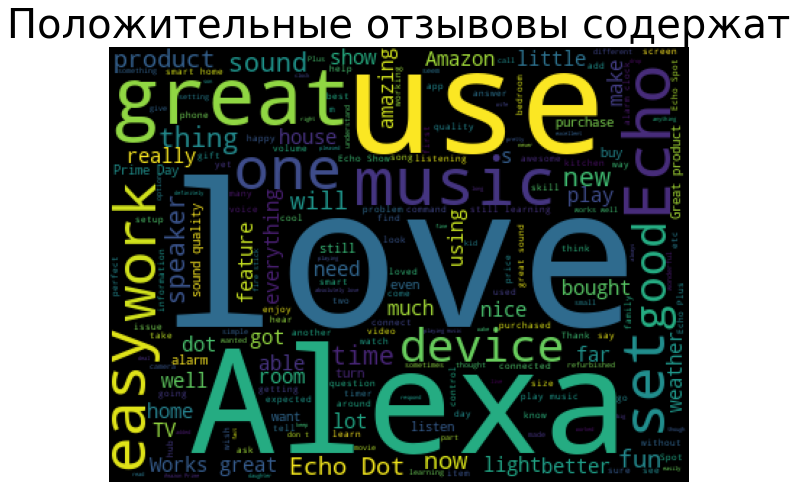

In [67]:
#Word Cloud для положительных отзывов
from wordcloud import WordCloud
plt.figure(figsize=(14,8))
wordcloud1=WordCloud(width=400,height=300, contour_color='black').generate(' '.join(positive_feedbacks))
plt.imshow(wordcloud1)
plt.axis('off')
plt.title('Положительные отзывовы содержат',fontsize=40)

Text(0.5, 1.0, 'Отрицательные отзывовы содержат')

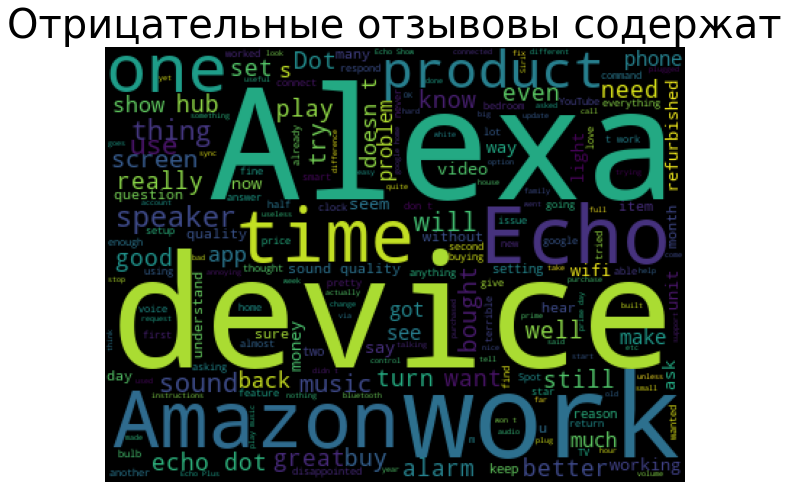

In [66]:
#Word Cloud отрицательных отзывов
plt.figure(figsize=(14,8))
wordcloud2=WordCloud(width=400,height=300, contour_color='black').generate(' '.join(negative_feedbacks))
plt.imshow(wordcloud2)
plt.axis('off')
plt.title('Отрицательные отзывовы содержат',fontsize=40)

In [21]:
#Tfidf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVect=TfidfVectorizer(max_features=1500,stop_words='english')

X=tfidfVect.fit_transform(data['verified_reviews']).toarray()
y=data.iloc[:,4].values
print(tfidfVect.get_feature_names())

['abilities', 'ability', 'able', 'absolutely', 'ac', 'accent', 'access', 'account', 'accounts', 'act', 'activated', 'actually', 'adapter', 'add', 'added', 'addicted', 'adding', 'addition', 'additional', 'adequate', 'adjust', 'advanced', 'advantage', 'advertised', 'advertising', 'advise', 'ago', 'ai', 'al', 'alarm', 'alarms', 'alert', 'alex', 'alexa', 'alexas', 'alexi', 'alexia', 'allow', 'allows', 'amazed', 'amazing', 'amazingly', 'amazon', 'amazons', 'american', 'android', 'annoying', 'answer', 'answered', 'answering', 'answers', 'anticipated', 'anymore', 'anypod', 'anytime', 'apartment', 'app', 'apparently', 'appear', 'appears', 'apple', 'application', 'appointments', 'apps', 'area', 'aren', 'arent', 'arlo', 'arrived', 'artist', 'ask', 'asked', 'asking', 'asleep', 'assist', 'assistant', 'attached', 'attempt', 'attention', 'attractive', 'audible', 'audio', 'audiobook', 'audiophile', 'automatic', 'automation', 'auxiliary', 'available', 'aware', 'away', 'awesome', 'awful', 'awhile', 'ba

/Users/denis/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
#Shape tfidf vectorizer
X.shape

(3150, 1500)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 100)

# Модели

# 1. Naive Bayes Model

In [24]:
from sklearn.naive_bayes import MultinomialNB
model1=MultinomialNB()
model1.fit(X_train, y_train)

MultinomialNB()

In [25]:
y_pred=model1.predict(X_test)

In [72]:
from sklearn.metrics import classification_report,confusion_matrix,precision_score,recall_score,f1_score,accuracy_score,roc_auc_score
print('Classification Report',classification_report(y_test,y_pred))
print('Confusion Matrix',confusion_matrix(y_test,y_pred))
print('Accuracy Score',accuracy_score(y_test,y_pred))
print('Precision Score',precision_score(y_test,y_pred))
print('Recall Score',recall_score(y_test,y_pred))
print('F1 Score',f1_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_pred))

Classification Report               precision    recall  f1-score   support

           0       1.00      0.06      0.11        68
           1       0.92      1.00      0.96       720

    accuracy                           0.92       788
   macro avg       0.96      0.53      0.53       788
weighted avg       0.93      0.92      0.88       788

Confusion Matrix [[  4  64]
 [  0 720]]
Accuracy Score 0.9187817258883249
Precision Score 0.9183673469387755
Recall Score 1.0
F1 Score 0.9574468085106383
roc_auc_score 0.5294117647058824


In [70]:
#Cross Validation
from sklearn.model_selection import cross_val_score
cross_val_score(model1,X=X_train,y=y_train,cv=5)

array([0.9217759 , 0.91966173, 0.92161017, 0.91949153, 0.92161017])

# 2. Logistic regression

In [28]:
from sklearn.linear_model import LogisticRegression
model2=LogisticRegression()
model2.fit(X_train,y_train)

LogisticRegression()

In [29]:
y_pred2=model2.predict(X_test)

In [73]:
from sklearn.metrics import classification_report,confusion_matrix,precision_score,recall_score,f1_score,accuracy_score,roc_auc_score
print('Classification Report',classification_report(y_test,y_pred2))
print('Confusion Matrix',confusion_matrix(y_test,y_pred2))
print('Accuracy Score',accuracy_score(y_test,y_pred2))
print('Precision Score',precision_score(y_test,y_pred2))
print('Recall Score',recall_score(y_test,y_pred2))
print('F1 Score',f1_score(y_test,y_pred2))
print('roc_auc_score',roc_auc_score(y_test,y_pred2))

Classification Report               precision    recall  f1-score   support

           0       1.00      0.03      0.06        68
           1       0.92      1.00      0.96       720

    accuracy                           0.92       788
   macro avg       0.96      0.51      0.51       788
weighted avg       0.92      0.92      0.88       788

Confusion Matrix [[  2  66]
 [  0 720]]
Accuracy Score 0.916243654822335
Precision Score 0.916030534351145
Recall Score 1.0
F1 Score 0.9561752988047809
roc_auc_score 0.5147058823529411


In [31]:
#Cross Validation
from sklearn.model_selection import cross_val_score
cross_val_score(model2,X=X_train,y=y_train,cv=5)

array([0.91966173, 0.91966173, 0.92372881, 0.91949153, 0.91949153])

# Random Forest Classifier

In [32]:
from sklearn.ensemble import RandomForestClassifier
model3=RandomForestClassifier()
model3.fit(X_train,y_train)

RandomForestClassifier()

In [33]:
y_pred3=model3.predict(X_test)

In [39]:
from sklearn.metrics import classification_report,confusion_matrix,precision_score,recall_score,f1_score,accuracy_score,roc_auc_score

print('Classification Report',classification_report(y_test,y_pred3))
print('Confusion Matrix',confusion_matrix(y_test,y_pred3))
print('Accuracy Score',accuracy_score(y_test,y_pred3))
print('Precision Score',precision_score(y_test,y_pred3))
print('Recall Score',recall_score(y_test,y_pred3))
print('F1 Score',f1_score(y_test,y_pred3))
print('roc_auc_score',roc_auc_score(y_test,y_pred3))

Classification Report               precision    recall  f1-score   support

           0       0.95      0.26      0.41        68
           1       0.93      1.00      0.97       720

    accuracy                           0.94       788
   macro avg       0.94      0.63      0.69       788
weighted avg       0.94      0.94      0.92       788

Confusion Matrix [[ 18  50]
 [  1 719]]
Accuracy Score 0.9352791878172588
Precision Score 0.9349804941482445
Recall Score 0.9986111111111111
F1 Score 0.9657488247145736
roc_auc_score 0.6316584967320261


In [35]:
#Cross Validation
from sklearn.model_selection import cross_val_score
cross_val_score(model3,X=X_train,y=y_train,cv=5)

array([0.93023256, 0.92811839, 0.92584746, 0.93220339, 0.92161017])